In [4]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.applications import InceptionV3
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

# Define constants and hyperparameters
CONFIG = {
    'INPUT_IMAGE_SIZE': (48, 48),
    'TRAIN_BATCH_SIZE': 64,
    'TEST_BATCH_SIZE': 64,
    'EPOCHS': 40,
    'LEARNING_RATE': 0.0001,
    'WEIGHT_DECAY': 0.001,
}

# Define the custom model architecture
def create_custom_model(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Dilated Convolutional Layers
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Classification Layers
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=CONFIG['LEARNING_RATE'],
        weight_decay=CONFIG['WEIGHT_DECAY']
    )
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Define the transfer learning model using InceptionV3
def create_transfer_model(input_shape, num_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=CONFIG['LEARNING_RATE'],
        weight_decay=CONFIG['WEIGHT_DECAY']
    )
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Load and preprocess the data
def load_data(train_dir, test_dir, img_size, train_batch_size, test_batch_size):
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        horizontal_flip=True,
        rotation_range=20,
        zoom_range=0.2,
        shear_range=0.2
    )
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)

    train_data = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        color_mode='rgb',
        batch_size=train_batch_size,
        class_mode='categorical',
        shuffle=True
    )

    if test_dir:
        test_data = test_datagen.flow_from_directory(
            test_dir,
            target_size=img_size,
            color_mode='rgb',
            batch_size=test_batch_size,
            class_mode='categorical',
            shuffle=False
        )
    else:
        test_data = None

    return train_data, test_data

# Train and evaluate the model
def train_and_evaluate_model(model, train_data, test_data, epochs, callbacks):
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=test_data,
        callbacks=callbacks,
        verbose=1
    )

    if test_data:
        test_loss, test_accuracy = model.evaluate(test_data)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return history

# Plot training and validation metrics
def plot_metrics(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.show()

# Evaluate the model and display classification metrics
def evaluate_model(model, test_data, model_name):
    predictions = model.predict(test_data)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_data.classes
    class_labels = list(test_data.class_indices.keys())

    print(f"Classification Report for {model_name}:")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()

In [5]:
train_dir = 'data/train'
test_dir = 'data/test'

train_data, test_data = load_data(
    train_dir,
    test_dir,
    img_size=CONFIG['INPUT_IMAGE_SIZE'],
    train_batch_size=CONFIG['TRAIN_BATCH_SIZE'],
    test_batch_size=CONFIG['TEST_BATCH_SIZE']
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 24, 24, 32)        128       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 32)        0   

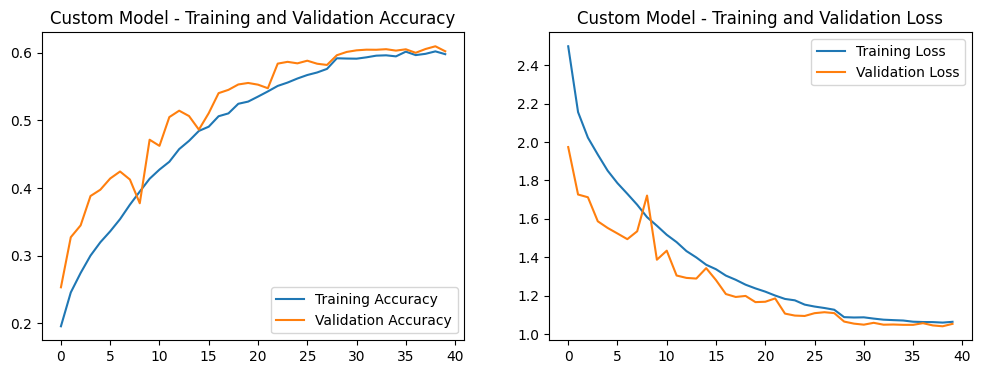

113/113 [==============================] - 3s 27ms/step
Classification Report for Custom Model:
              precision    recall  f1-score   support

       angry       0.46      0.59      0.52       958
     disgust       0.71      0.23      0.34       111
        fear       0.51      0.29      0.37      1024
       happy       0.82      0.83      0.83      1774
     neutral       0.51      0.64      0.57      1233
         sad       0.49      0.43      0.46      1247
    surprise       0.70      0.76      0.73       831

    accuracy                           0.60      7178
   macro avg       0.60      0.54      0.54      7178
weighted avg       0.60      0.60      0.59      7178



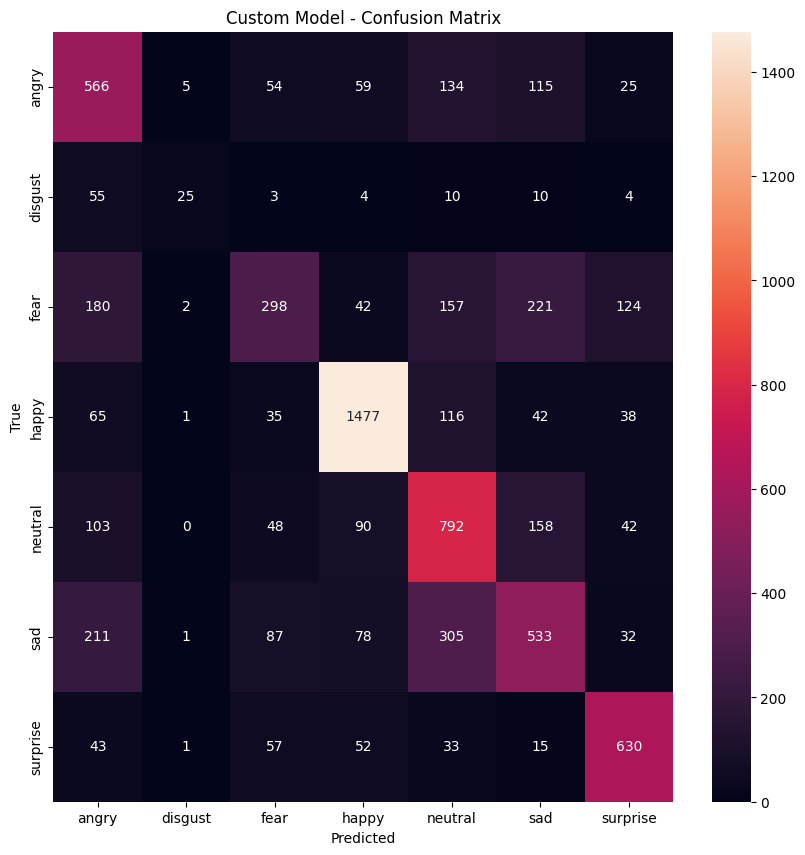

In [6]:
from tensorflow.keras.utils import plot_model

# Custom model
custom_model = create_custom_model(input_shape=(*CONFIG['INPUT_IMAGE_SIZE'], 3), num_classes=7)
custom_model.summary()

# Use plot_model to create a diagram of the model
plot_model(custom_model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)

log_dir_custom = "logs/fit/custom_" + datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks_custom = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1),
    ModelCheckpoint('best_custom_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
    TensorBoard(log_dir=log_dir_custom, histogram_freq=1)
]

history_custom = train_and_evaluate_model(custom_model, train_data, test_data, CONFIG['EPOCHS'], callbacks_custom)
plot_metrics(history_custom, 'Custom Model')

custom_model.save('custom_emotion_detection_model.keras')

if test_data:
    evaluate_model(custom_model, test_data, 'Custom Model')

In [7]:
# Save model as h5 file
custom_model.save('custom_emotion_detection_model.h5')

d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
# opening webcam and detecting emotions in real time using the trained model
import cv2
from tensorflow.keras.models import load_model
import numpy as np

# Load the trained model
model = load_model('custom_emotion_detection_model.h5')

# Define the emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Open the webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the image to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        # Draw a rectangle around the face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

        # Crop the face
        face = gray[y:y+h, x:x+w]
        face = cv2.resize(face, (48, 48))
        face = np.expand_dims(face, axis=0)
        face = np.expand_dims(face, axis=3)

        # Predict the emotion
        prediction = model.predict(face)
        predicted_class = np.argmax(prediction)
        label = emotion_labels[predicted_class]

        # Display the emotion
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame, label, (x, y-10), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Display the frame
    cv2.imshow('Emotion Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


ValueError: in user code:

    File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "d:\git\MLOps\Fraud-Detection-System-MLOps\fraudEnv\lib\site-packages\keras\src\engine\input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model_1' (type Functional).
    
    Input 0 of layer "conv2d_6" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 48, 48, 1)
    
    Call arguments received by layer 'model_1' (type Functional):
      • inputs=tf.Tensor(shape=(None, 48, 48, 1), dtype=uint8)
      • training=False
      • mask=None


: 